In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

# Set up Network

In [51]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.03, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 6
extraNin: int = 0
Ninter: int = 0
Nout: int = 1
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = 2*array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
# R_vec_i = np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 4000  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# include_Power: bool = True
include_Power: bool = False
lam = -80**(1)
lam2 = -5*10**(-3)
# lam2 = +10**(-1)  # lambda parameter for penalty on Power dissipation\
# lam = 5.0  # lambda parameter for penalty on Power dissipation

stay_sample: int = 20  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 100

## Networkx sizes
scale: float = 50.0
squish: float = 0.01

In [52]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [53]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         include_Power, lam, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [0.5]
input M mismatches output and input


In [54]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [7]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [1 2 3 4 5 6]
extraOutput_nodes_arr  []
ground_nodes_arr  [7]


In [8]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [9]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [10]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

R_vec_i has wrong size, initializing all ones


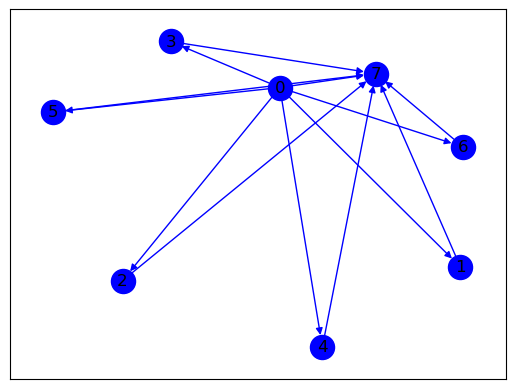

NET is ready


In [11]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [12]:
Strctr.EIEJ_plots

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 7),
 (2, 7),
 (3, 7),
 (4, 7),
 (5, 7),
 (6, 7)]

# Train

In [13]:
for i in range(Variabs.iterations):
    print('i', i)
    
#     # if i<(200):
#     if i<(iterations/2):
#         pass
#     else:
#         # Variabs.R_update = 'deltaR_propto_Q'
#         Variabs.lam = lam2
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")
        
    if include_Power:
        State.calc_Power_norm(BigClass)
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        print('loss', State.loss)
        loss_mean = np.mean(np.abs(State.loss), axis=1)
        Variabs.lam = copy.copy(Variabs.lam) * (10**(-7) / loss_mean) ** 0.001
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        # print('p', State.p)
        # print('u', State.u)
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
i 1
k 1
time= 1
loss [[-0.92219288 -0.91268573 -0.90317859 -0.93170002 -0.94691145 -0.94501002]
 [-0.36330392 -0.35955851 -0.35581311 -0.36704932 -0.37304196 -0.37229288]]
solving dual problem
updating Rs
i 2
k 0
i 3
k 1
time= 2
loss [[-0.37616054 -0.36745403 -0.35874752 -0.38486705 -0.39879746 -0.39705616]
 [-0.1481909  -0.14476092 -0.14133093 -0.15162089 -0.15710887 -0.15642287]]
solving dual problem
updating Rs
i 4
k 0
i 5
k 1
time= 3
loss [[-0.29687087 -0.2882676  -0.27966536 -0.30547516 -0.31924416 -0.31752289]
 [-0.11695422 -0.11356491 -0.110176   -0.12034394 -0.12576833 -0.12509022]]
solving dual problem
updating Rs
i 6
k 0
i 7
k 1
time= 4
loss [[-0.25235689 -0.24381251 -0.23527    -0.26090316 -0.27458107 -0.27287107]
 [-0.09941765 -0.09605153 -0.09268616 -0.1027845  -0.10817301 -0.10749934]]
solving dual problem
updating Rs
i 8
k 0
i 9
k 1
time= 5
loss [[-0.2226051  -0.21410107 -0.20559966 -0.23111175 -0.24472782 -0.24302545]
 [-0.08769673 -0.08434652 -0.08099733 -0.091

time= 91
loss [[-0.01262497 -0.01014238 -0.00766758 -0.01511523 -0.0191153  -0.01861425]
 [-0.0187251  -0.01504297 -0.01137239 -0.0224186  -0.02835142 -0.02760828]]
solving dual problem
updating Rs
i 182
k 18
i 183
k 19
time= 92
loss [[-0.01261714 -0.0101346  -0.00765985 -0.01510735 -0.01910736 -0.01860632]
 [-0.01871347 -0.01503142 -0.01136092 -0.02240691 -0.02833964 -0.02759651]]
solving dual problem
updating Rs
i 184
k 18
i 185
k 19
time= 93
loss [[-0.01260931 -0.01012682 -0.00765212 -0.01509948 -0.01909943 -0.01859839]
 [-0.01870187 -0.01501989 -0.01134947 -0.02239523 -0.02832788 -0.02758475]]
solving dual problem
updating Rs
i 186
k 18
i 187
k 19
time= 94
loss [[-0.01260149 -0.01011905 -0.00764441 -0.01509162 -0.01909151 -0.01859048]
 [-0.01869027 -0.01500837 -0.01133803 -0.02238357 -0.02831613 -0.02757301]]
solving dual problem
updating Rs
i 188
k 18
i 189
k 19
time= 95
loss [[-0.01259369 -0.01011129 -0.00763671 -0.01508377 -0.01908359 -0.01858257]
 [-0.01867869 -0.01499686 -0.01

i 443
k 45
time= 222
loss [[-0.01508698 -0.00956826 -0.00408121 -0.02063663 -0.02957861 -0.02845674]
 [-0.00589295 -0.00373734 -0.00159411 -0.00806063 -0.01155335 -0.01111515]]
solving dual problem
updating Rs
i 444
k 44
i 445
k 45
time= 223
loss [[-0.01504252 -0.00952446 -0.00403815 -0.02059159 -0.02953279 -0.028411  ]
 [-0.00587558 -0.00372024 -0.00157729 -0.00804304 -0.01153545 -0.01109728]]
solving dual problem
updating Rs
i 446
k 44
i 447
k 45
time= 224
loss [[-0.01499829 -0.00948089 -0.00399531 -0.02054677 -0.02948718 -0.02836548]
 [-0.0058583  -0.00370322 -0.00156056 -0.00802553 -0.01151764 -0.0110795 ]]
solving dual problem
updating Rs
i 448
k 44
i 449
k 45
time= 225
loss [[-0.01495427 -0.00943753 -0.00395269 -0.02050217 -0.02944179 -0.02832018]
 [-0.00584111 -0.00368628 -0.00154391 -0.00800811 -0.01149991 -0.01106181]]
solving dual problem
updating Rs
i 450
k 44
i 451
k 45
time= 226
loss [[-0.01491047 -0.00939438 -0.00391028 -0.02045779 -0.02939662 -0.0282751 ]
 [-0.005824   -

updating Rs
i 672
k 66
i 673
k 67
time= 337
loss [[-0.01508559 -0.00845655 -0.00187229 -0.02175824 -0.03252235 -0.03117104]
 [-0.00265013 -0.00148559 -0.00032891 -0.00382233 -0.00571329 -0.00547591]]
solving dual problem
updating Rs
i 674
k 66
i 675
k 67
time= 338
loss [[-0.01497985 -0.00835281 -0.0017708  -0.02165073 -0.03241248 -0.03106144]
 [-0.00263155 -0.00146736 -0.00031108 -0.00380345 -0.00569399 -0.00545665]]
solving dual problem
updating Rs
i 676
k 66
i 677
k 67
time= 339
loss [[-0.01487526 -0.00825022 -0.00167045 -0.02154438 -0.03230378 -0.03095301]
 [-0.00261318 -0.00144934 -0.00029345 -0.00378476 -0.0056749  -0.0054376 ]]
solving dual problem
updating Rs
i 678
k 66
i 679
k 67
time= 340
loss [[-0.0147718  -0.00814876 -0.00157123 -0.02143917 -0.03219622 -0.03084571]
 [-0.002595   -0.00143152 -0.00027602 -0.00376628 -0.005656   -0.00541875]]
solving dual problem
updating Rs
i 680
k 68
i 681
k 69
time= 341
loss [[-0.01804682 -0.0099014  -0.00181227 -0.02624706 -0.03947783 -0.03

updating Rs
i 742
k 74
i 743
k 75
time= 372
loss [[-0.01017947 -0.00423467  0.0016593  -0.01617358 -0.02586295 -0.02464529]
 [-0.00987018 -0.00410601  0.00160888 -0.01568217 -0.02507714 -0.02389648]]
solving dual problem
updating Rs
i 744
k 74
i 745
k 75
time= 373
loss [[-0.0101794  -0.0042346   0.00165936 -0.01617351 -0.02586288 -0.02464522]
 [-0.00987012 -0.00410594  0.00160895 -0.0156821  -0.02507707 -0.02389641]]
solving dual problem
updating Rs
i 746
k 74
i 747
k 75
time= 374
loss [[-0.01017933 -0.00423454  0.00165943 -0.01617343 -0.0258628  -0.02464515]
 [-0.00987005 -0.00410588  0.00160901 -0.01568203 -0.025077   -0.02389634]]
solving dual problem
updating Rs
i 748
k 74
i 749
k 75
time= 375
loss [[-0.01017926 -0.00423447  0.00165949 -0.01617336 -0.02586273 -0.02464507]
 [-0.00986998 -0.00410581  0.00160907 -0.01568196 -0.02507693 -0.02389627]]
solving dual problem
updating Rs
i 750
k 74
i 751
k 75
time= 376
loss [[-0.0101792  -0.0042344   0.00165956 -0.01617329 -0.02586266 -0.02

i 931
k 93
time= 466
loss [[-0.00663875 -0.00209739  0.00240006 -0.01122261 -0.01864168 -0.01770873]
 [-0.00899852 -0.00284291  0.00325318 -0.01521172 -0.02526793 -0.02400336]]
solving dual problem
updating Rs
i 932
k 92
i 933
k 93
time= 467
loss [[-0.00663528 -0.00209403  0.00240329 -0.01121904 -0.01863798 -0.01770505]
 [-0.00899382 -0.00283837  0.00325755 -0.01520688 -0.02526292 -0.02399837]]
solving dual problem
updating Rs
i 934
k 92
i 935
k 93
time= 468
loss [[-0.00663182 -0.00209068  0.00240651 -0.01121548 -0.01863429 -0.01770137]
 [-0.00898912 -0.00283382  0.00326191 -0.01520205 -0.02525791 -0.02399338]]
solving dual problem
updating Rs
i 936
k 92
i 937
k 93
time= 469
loss [[-0.00662836 -0.00208733  0.00240973 -0.01121191 -0.0186306  -0.0176977 ]
 [-0.00898443 -0.00282928  0.00326628 -0.01519723 -0.02525291 -0.0239884 ]]
solving dual problem
updating Rs
i 938
k 92
i 939
k 93
time= 470
loss [[-0.0066249  -0.00208399  0.00241295 -0.01120835 -0.01862691 -0.01769402]
 [-0.00897974 -

updating Rs
i 1012
k 100
i 1013
k 101
time= 507
loss [[-0.00720791 -0.00206935  0.00301797 -0.01239604 -0.02079602 -0.01973954]
 [-0.00035596 -0.00010219  0.00014904 -0.00061218 -0.00102701 -0.00097484]]
solving dual problem
updating Rs
i 1014
k 100
i 1015
k 101
time= 508
loss [[-0.00717377 -0.00203638  0.0030496  -0.01236088 -0.02075952 -0.01970319]
 [-0.00035428 -0.00010057  0.0001506  -0.00061044 -0.00102521 -0.00097304]]
solving dual problem
updating Rs
i 1016
k 100
i 1017
k 101
time= 509
loss [[-7.13983771e-03 -2.00362006e-03  3.08102342e-03 -1.23259250e-02
  -2.07232258e-02 -1.96670459e-02]
 [-3.52601531e-04 -9.89489580e-05  1.52156620e-04 -6.08716919e-04
  -1.02341838e-03 -9.71258841e-04]]
solving dual problem
updating Rs
i 1018
k 100
i 1019
k 101
time= 510
loss [[-7.10610860e-03 -1.97106326e-03  3.11224677e-03 -1.22911761e-02
  -2.06871416e-02 -1.96311097e-02]
 [-3.50935816e-04 -9.73411373e-05  1.53698588e-04 -6.07000843e-04
  -1.02163636e-03 -9.69484126e-04]]
solving dual prob

time= 595
loss [[-0.00519245 -0.00087192  0.00340041 -0.00955949 -0.01663939 -0.01574835]
 [-0.008593   -0.00144294  0.00562734 -0.01582003 -0.02753658 -0.02606199]]
solving dual problem
updating Rs
i 1190
k 118
i 1191
k 119
time= 596
loss [[-0.00518438 -0.00086418  0.00340777 -0.00955114 -0.01663066 -0.01573967]
 [-0.00857964 -0.00143013  0.00563953 -0.01580621 -0.02752213 -0.02604762]]
solving dual problem
updating Rs
i 1192
k 118
i 1193
k 119
time= 597
loss [[-0.00517632 -0.00085645  0.00341512 -0.0095428  -0.01662195 -0.01573099]
 [-0.00856631 -0.00141735  0.00565169 -0.0157924  -0.02750771 -0.02603327]]
solving dual problem
updating Rs
i 1194
k 118
i 1195
k 119
time= 598
loss [[-0.00516829 -0.00084874  0.00342245 -0.00953447 -0.01661325 -0.01572234]
 [-0.00855301 -0.00140459  0.00566382 -0.01577863 -0.02749332 -0.02601894]]
solving dual problem
updating Rs
i 1196
k 118
i 1197
k 119
time= 599
loss [[-0.00516026 -0.00084105  0.00342977 -0.00952616 -0.01660457 -0.0157137 ]
 [-0.00853

time= 639
loss [[-0.00811611 -0.00122807  0.00558205 -0.01507933 -0.02637012 -0.024949  ]
 [-0.00771333 -0.00116712  0.00530503 -0.01433098 -0.02506144 -0.02371084]]
solving dual problem
updating Rs
i 1278
k 126
i 1279
k 127
time= 640
loss [[-0.00811593 -0.00122789  0.00558222 -0.01507914 -0.02636992 -0.0249488 ]
 [-0.00771316 -0.00116695  0.00530518 -0.0143308  -0.02506125 -0.02371066]]
solving dual problem
updating Rs
i 1280
k 128
i 1281
k 129
time= 641
loss [[-4.81578643e-03 -7.28511706e-04  3.31251984e-03 -8.94767050e-03
  -1.56474799e-02 -1.48042033e-02]
 [-6.55509597e-05 -9.91627063e-06  4.50889710e-05 -1.21792857e-04
  -2.12988541e-04 -2.01510127e-04]]
solving dual problem
updating Rs
i 1282
k 128
i 1283
k 129
time= 642
loss [[-4.80062754e-03 -7.13986413e-04  3.32632172e-03 -8.93196278e-03
  -1.56310581e-02 -1.47878603e-02]
 [-6.53446217e-05 -9.71855694e-06  4.52768378e-05 -1.21579049e-04
  -2.12765012e-04 -2.01287671e-04]]
solving dual problem
updating Rs
i 1284
k 128
i 1285
k 

time= 730
loss [[-2.81586264e-04  1.05379878e-05  2.98880489e-04 -5.77348723e-04
  -1.05778547e-03 -9.97260598e-04]
 [-2.17440521e-03  8.13741952e-05  2.30795098e-03 -4.45827881e-03
  -8.16820472e-03 -7.70083246e-03]]
solving dual problem
updating Rs
i 1460
k 146
i 1461
k 147
time= 731
loss [[-0.00383449  0.00014631  0.00407554 -0.00786488 -0.0144119  -0.01358711]
 [-0.00464982  0.00017742  0.00494213 -0.0095372  -0.01747632 -0.01647615]]
solving dual problem
updating Rs
i 1462
k 146
i 1463
k 147
time= 732
loss [[-0.00383396  0.00014681  0.00407601 -0.00786433 -0.01441131 -0.01358653]
 [-0.00464918  0.00017803  0.0049427  -0.00953653 -0.01747561 -0.01647545]]
solving dual problem
updating Rs
i 1464
k 146
i 1465
k 147
time= 733
loss [[-0.00383343  0.00014731  0.00407648 -0.00786377 -0.01441073 -0.01358595]
 [-0.00464854  0.00017863  0.00494327 -0.00953586 -0.0174749  -0.01647475]]
solving dual problem
updating Rs
i 1466
k 146
i 1467
k 147
time= 734
loss [[-0.0038329   0.00014781  0.0040

updating Rs
i 1546
k 154
i 1547
k 155
time= 774
loss [[-0.00167771  0.00023009  0.00211172 -0.00361065 -0.00675316 -0.0063571 ]
 [-0.00683164  0.00093692  0.00859893 -0.01470258 -0.0274989  -0.02588616]]
solving dual problem
updating Rs
i 1548
k 154
i 1549
k 155
time= 775
loss [[-0.00166658  0.00024059  0.0021215  -0.00359898 -0.00674079 -0.00634481]
 [-0.00678632  0.00097969  0.00863876 -0.01465507 -0.02744855 -0.02583612]]
solving dual problem
updating Rs
i 1550
k 154
i 1551
k 155
time= 776
loss [[-0.00165552  0.00025102  0.00213121 -0.00358739 -0.00672851 -0.0063326 ]
 [-0.0067413   0.00102215  0.00867828 -0.01460786 -0.02739851 -0.02578639]]
solving dual problem
updating Rs
i 1552
k 154
i 1553
k 155
time= 777
loss [[-0.00164455  0.00026137  0.00214084 -0.00357587 -0.00671629 -0.00632047]
 [-0.0066966   0.0010643   0.0087175  -0.01456096 -0.02734879 -0.02573698]]
solving dual problem
updating Rs
i 1554
k 154
i 1555
k 155
time= 778
loss [[-0.00163364  0.00027165  0.0021504  -0.003564

updating Rs
i 1732
k 172
i 1733
k 173
time= 867
loss [[-0.00122228  0.0005411   0.00227669 -0.00301228 -0.00592881 -0.00556083]
 [-0.00276349  0.00122339  0.00514746 -0.00681057 -0.01340468 -0.0125727 ]]
solving dual problem
updating Rs
i 1734
k 172
i 1735
k 173
time= 868
loss [[-0.00122107  0.00054222  0.00227772 -0.003011   -0.00592744 -0.00555947]
 [-0.00276076  0.00122593  0.00514978 -0.00680768 -0.01340158 -0.01256962]]
solving dual problem
updating Rs
i 1736
k 172
i 1737
k 173
time= 869
loss [[-0.00121986  0.00054334  0.00227874 -0.00300972 -0.00592607 -0.00555811]
 [-0.00275804  0.00122847  0.00515209 -0.00680479 -0.01339848 -0.01256655]]
solving dual problem
updating Rs
i 1738
k 172
i 1739
k 173
time= 870
loss [[-0.00121866  0.00054447  0.00227976 -0.00300844 -0.0059247  -0.00555675]
 [-0.00275531  0.001231    0.00515441 -0.0068019  -0.01339538 -0.01256347]]
solving dual problem
updating Rs
i 1740
k 174
i 1741
k 175
time= 871
loss [[-0.00093725  0.00042002  0.00175585 -0.002315

time= 994
loss [[-0.00324609  0.00275129  0.00864137 -0.00934602 -0.01930756 -0.01804931]
 [-0.00369234  0.00312952  0.00982932 -0.01063083 -0.02196181 -0.02053058]]
solving dual problem
updating Rs
i 1988
k 198
i 1989
k 199
time= 995
loss [[-0.00324562  0.00275172  0.00864175 -0.00934551 -0.01930702 -0.01804877]
 [-0.0036918   0.00313001  0.00982975 -0.01063026 -0.02196119 -0.02052996]]
solving dual problem
updating Rs
i 1990
k 198
i 1991
k 199
time= 996
loss [[-0.00324515  0.00275215  0.00864214 -0.00934501 -0.01930647 -0.01804822]
 [-0.00369127  0.0031305   0.00983019 -0.01062968 -0.02196056 -0.02052935]]
solving dual problem
updating Rs
i 1992
k 198
i 1993
k 199
time= 997
loss [[-0.00324468  0.00275258  0.00864252 -0.0093445  -0.01930592 -0.01804768]
 [-0.00369073  0.00313099  0.00983062 -0.01062911 -0.02195994 -0.02052873]]
solving dual problem
updating Rs
i 1994
k 198
i 1995
k 199
time= 998
loss [[-0.00324421  0.00275301  0.0086429  -0.009344   -0.01930537 -0.01804714]
 [-0.00369

i 2089
k 209
time= 1045
loss [[-5.48153739e-04  6.77411129e-04  1.87907026e-03 -1.79652369e-03
  -3.83865695e-03 -3.58049763e-03]
 [-1.72536517e-05  2.13221490e-05  5.91454942e-05 -5.65472636e-05
  -1.20825318e-04 -1.12699512e-04]]
solving dual problem
updating Rs
i 2090
k 208
i 2091
k 209
time= 1046
loss [[-5.47977333e-04  6.77570234e-04  1.87920926e-03 -1.79633260e-03
  -3.83844735e-03 -3.58029002e-03]
 [-1.72480992e-05  2.13271570e-05  5.91498692e-05 -5.65412489e-05
  -1.20818721e-04 -1.12692978e-04]]
solving dual problem
updating Rs
i 2092
k 208
i 2093
k 209
time= 1047
loss [[-5.47800967e-04  6.77729299e-04  1.87934821e-03 -1.79614155e-03
  -3.83823778e-03 -3.58008246e-03]
 [-1.72425479e-05  2.13321637e-05  5.91542430e-05 -5.65352354e-05
  -1.20812125e-04 -1.12686444e-04]]
solving dual problem
updating Rs
i 2094
k 208
i 2095
k 209
time= 1048
loss [[-5.47624640e-04  6.77888325e-04  1.87948713e-03 -1.79595054e-03
  -3.83802826e-03 -3.57987493e-03]
 [-1.72369978e-05  2.13371692e-05  5

time= 1117
loss [[-0.00113851  0.00165234  0.00438665 -0.00398329 -0.00864058 -0.00805159]
 [-0.00029003  0.00042093  0.00111749 -0.00101473 -0.00220117 -0.00205112]]
solving dual problem
updating Rs
i 2234
k 222
i 2235
k 223
time= 1118
loss [[-0.00113735  0.00165339  0.00438755 -0.00398201 -0.00863918 -0.0080502 ]
 [-0.00028974  0.0004212   0.00111772 -0.00101441 -0.00220081 -0.00205077]]
solving dual problem
updating Rs
i 2236
k 222
i 2237
k 223
time= 1119
loss [[-0.00113618  0.00165444  0.00438846 -0.00398074 -0.00863778 -0.00804882]
 [-0.00028944  0.00042146  0.00111795 -0.00101408 -0.00220045 -0.00205042]]
solving dual problem
updating Rs
i 2238
k 222
i 2239
k 223
time= 1120
loss [[-0.00113501  0.00165548  0.00438936 -0.00397947 -0.00863637 -0.00804743]
 [-0.00028914  0.00042173  0.00111818 -0.00101376 -0.0022001  -0.00205006]]
solving dual problem
updating Rs
i 2240
k 224
i 2241
k 225
time= 1121
loss [[-0.00075234  0.00109915  0.00291306 -0.00263965 -0.00572955 -0.00533877]
 [-0.

i 2355
k 235
time= 1178
loss [[-0.00202277  0.00343748  0.00878283 -0.00759245 -0.01671822 -0.01556367]
 [-0.00054665  0.00092898  0.00237356 -0.00205186 -0.00451811 -0.00420609]]
solving dual problem
updating Rs
i 2356
k 234
i 2357
k 235
time= 1179
loss [[-0.00201479  0.00344457  0.0087889  -0.00758374 -0.01670857 -0.01555412]
 [-0.0005445   0.0009309   0.0023752  -0.00204951 -0.0045155  -0.00420351]]
solving dual problem
updating Rs
i 2358
k 234
i 2359
k 235
time= 1180
loss [[-0.00200684  0.00345164  0.00879494 -0.00757504 -0.01669893 -0.01554458]
 [-0.00054235  0.00093281  0.00237684 -0.00204716 -0.00451289 -0.00420093]]
solving dual problem
updating Rs
i 2360
k 236
i 2361
k 237
time= 1181
loss [[-6.72784132e-05  1.16411158e-04  2.96218812e-04 -2.54665157e-04
  -5.61721563e-04 -5.22872328e-04]
 [-7.76852488e-04  1.34418001e-03  3.42038866e-03 -2.94057561e-03
  -6.48610413e-03 -6.03751856e-03]]
solving dual problem
updating Rs
i 2362
k 236
i 2363
k 237
time= 1182
loss [[-6.72153782e-

i 2509
k 251
time= 1255
loss [[-0.00082236  0.00205785  0.00487174 -0.00376561 -0.00859796 -0.00798598]
 [-0.00062878  0.00157345  0.00372497 -0.00287922 -0.00657407 -0.00610614]]
solving dual problem
updating Rs
i 2510
k 250
i 2511
k 251
time= 1256
loss [[-0.00082225  0.00205794  0.00487181 -0.00376549 -0.00859782 -0.00798585]
 [-0.0006287   0.00157352  0.00372503 -0.00287912 -0.00657397 -0.00610604]]
solving dual problem
updating Rs
i 2512
k 250
i 2513
k 251
time= 1257
loss [[-0.00082214  0.00205804  0.00487189 -0.00376537 -0.00859769 -0.00798571]
 [-0.00062862  0.00157359  0.00372509 -0.00287903 -0.00657386 -0.00610594]]
solving dual problem
updating Rs
i 2514
k 250
i 2515
k 251
time= 1258
loss [[-0.00082203  0.00205813  0.00487197 -0.00376525 -0.00859755 -0.00798558]
 [-0.00062853  0.00157366  0.00372515 -0.00287894 -0.00657376 -0.00610584]]
solving dual problem
updating Rs
i 2516
k 250
i 2517
k 251
time= 1259
loss [[-0.00082192  0.00205822  0.00487205 -0.00376513 -0.00859742 -0.00

updating Rs
i 2616
k 260
i 2617
k 261
time= 1309
loss [[-0.00184248  0.00552647  0.01271886 -0.00937917 -0.02176513 -0.02019582]
 [-0.00114452  0.00343297  0.00790077 -0.00582621 -0.01352019 -0.01254535]]
solving dual problem
updating Rs
i 2618
k 260
i 2619
k 261
time= 1310
loss [[-0.00183805  0.00553029  0.01272198 -0.00937424 -0.02175957 -0.02019032]
 [-0.00114177  0.00343534  0.00790271 -0.00582314 -0.01351673 -0.01254194]]
solving dual problem
updating Rs
i 2620
k 262
i 2621
k 263
time= 1311
loss [[-0.00095998  0.00289731  0.00666205 -0.00490518 -0.01138903 -0.0105675 ]
 [-0.00025944  0.00078303  0.00180049 -0.00132568 -0.003078   -0.00285598]]
solving dual problem
updating Rs
i 2622
k 262
i 2623
k 263
time= 1312
loss [[-0.00095762  0.00289934  0.00666371 -0.00490256 -0.01138607 -0.01056458]
 [-0.00025881  0.00078358  0.00180094 -0.00132497 -0.0030772  -0.00285519]]
solving dual problem
updating Rs
i 2624
k 262
i 2625
k 263
time= 1313
loss [[-0.00095528  0.00290137  0.00666536 -0.0

time= 1385
loss [[-0.00116752  0.00366438  0.00837939 -0.00611045 -0.01423571 -0.01320611]
 [-0.00143396  0.00450065  0.01029168 -0.00750495 -0.01748451 -0.01621994]]
solving dual problem
updating Rs
i 2770
k 276
i 2771
k 277
time= 1386
loss [[-0.00116707  0.00366477  0.0083797  -0.00610995 -0.01423515 -0.01320556]
 [-0.00143341  0.00450112  0.01029207 -0.00750433 -0.01748382 -0.01621926]]
solving dual problem
updating Rs
i 2772
k 276
i 2773
k 277
time= 1387
loss [[-0.00116662  0.00366515  0.00838001 -0.00610945 -0.01423458 -0.013205  ]
 [-0.00143286  0.0045016   0.01029245 -0.00750372 -0.01748312 -0.01621857]]
solving dual problem
updating Rs
i 2774
k 276
i 2775
k 277
time= 1388
loss [[-0.00116618  0.00366554  0.00838032 -0.00610895 -0.01423402 -0.01320444]
 [-0.00143231  0.00450207  0.01029284 -0.00750311 -0.01748243 -0.01621789]]
solving dual problem
updating Rs
i 2776
k 276
i 2777
k 277
time= 1389
loss [[-0.00116573  0.00366592  0.00838064 -0.00610846 -0.01423346 -0.01320389]
 [-0.

time= 1427
loss [[-5.81639862e-05  2.08131112e-04  4.67807200e-04 -3.30742941e-04
  -7.79116364e-04 -7.22281730e-04]
 [-9.35808301e-04  3.34864982e-03  7.52661379e-03 -5.32136825e-03
  -1.25353093e-02 -1.16208892e-02]]
solving dual problem
updating Rs
i 2854
k 284
i 2855
k 285
time= 1428
loss [[-5.78486664e-05  2.08400879e-04  4.68023586e-04 -3.30389337e-04
  -7.78715220e-04 -7.21885668e-04]
 [-9.30735077e-04  3.35299014e-03  7.53009525e-03 -5.31567906e-03
  -1.25288553e-02 -1.16145169e-02]]
solving dual problem
updating Rs
i 2856
k 284
i 2857
k 285
time= 1429
loss [[-5.75340790e-05  2.08669920e-04  4.68239251e-04 -3.30036472e-04
  -7.78314830e-04 -7.21490358e-04]
 [-9.25673637e-04  3.35731878e-03  7.53356512e-03 -5.31000178e-03
  -1.25224134e-02 -1.16081567e-02]]
solving dual problem
updating Rs
i 2858
k 284
i 2859
k 285
time= 1430
loss [[-5.72202216e-05  2.08938237e-04  4.68454198e-04 -3.29684345e-04
  -7.77915191e-04 -7.21095797e-04]
 [-9.20623943e-04  3.36163577e-03  7.53702342e-03

updating Rs
i 3040
k 304
i 3041
k 305
time= 1521
loss [[-0.00118712  0.00598335  0.01296379 -0.00853776 -0.02064937 -0.01911289]
 [-0.00088328  0.00445196  0.00964582 -0.0063526  -0.01536434 -0.01422112]]
solving dual problem
updating Rs
i 3042
k 304
i 3043
k 305
time= 1522
loss [[-0.00118549  0.00598472  0.01296485 -0.00853592 -0.02064725 -0.01911081]
 [-0.00088207  0.00445298  0.00964661 -0.00635123 -0.01536277 -0.01421956]]
solving dual problem
updating Rs
i 3044
k 304
i 3045
k 305
time= 1523
loss [[-0.00118386  0.00598608  0.01296591 -0.00853408 -0.02064514 -0.01910872]
 [-0.00088086  0.004454    0.0096474  -0.00634985 -0.0153612  -0.01421801]]
solving dual problem
updating Rs
i 3046
k 304
i 3047
k 305
time= 1524
loss [[-0.00118224  0.00598744  0.01296697 -0.00853223 -0.02064303 -0.01910664]
 [-0.00087966  0.00445501  0.00964819 -0.00634848 -0.01535962 -0.01421646]]
solving dual problem
updating Rs
i 3048
k 304
i 3049
k 305
time= 1525
loss [[-0.00118062  0.00598881  0.01296803 -0.0

updating Rs
i 3118
k 310
i 3119
k 311
time= 1560
loss [[-8.53180794e-05  4.89522041e-04  1.04879636e-03 -6.74911907e-04
  -1.64695047e-03 -1.52360310e-03]
 [-4.77363318e-04  2.73892553e-03  5.86812216e-03 -3.77620066e-03
  -9.21485513e-03 -8.52471405e-03]]
solving dual problem
updating Rs
i 3120
k 312
i 3121
k 313
time= 1561
loss [[-1.04361973e-03  6.00905062e-03  1.28706373e-02 -8.27740279e-03
  -2.02036222e-02 -1.86902267e-02]
 [-2.74830723e-05  1.58244587e-04  3.38940176e-04 -2.17980221e-04
  -5.32049744e-04 -4.92195421e-04]]
solving dual problem
updating Rs
i 3122
k 312
i 3123
k 313
time= 1562
loss [[-1.02188379e-03  6.02717596e-03  1.28845194e-02 -8.25264301e-03
  -2.01751292e-02 -1.86621311e-02]
 [-2.69106700e-05  1.58721906e-04  3.39305753e-04 -2.17328188e-04
  -5.31299399e-04 -4.91455542e-04]]
solving dual problem
updating Rs
i 3124
k 312
i 3125
k 313
time= 1563
loss [[-1.00029085e-03  6.04515964e-03  1.28982609e-02 -8.22802782e-03
  -2.01467837e-02 -1.86341827e-02]
 [-2.634203

i 3271
k 327
time= 1636
loss [[-0.00048464  0.00396619  0.00829016 -0.0050556  -0.01260239 -0.01164408]
 [-0.00043919  0.00359424  0.00751271 -0.00458149 -0.01142055 -0.0105521 ]]
solving dual problem
updating Rs
i 3272
k 326
i 3273
k 327
time= 1637
loss [[-0.0004846   0.00396622  0.00829019 -0.00505554 -0.01260233 -0.01164401]
 [-0.00043915  0.00359428  0.00751274 -0.00458144 -0.01142049 -0.01055205]]
solving dual problem
updating Rs
i 3274
k 326
i 3275
k 327
time= 1638
loss [[-0.00048455  0.00396626  0.00829022 -0.00505549 -0.01260226 -0.01164395]
 [-0.00043911  0.00359431  0.00751277 -0.00458139 -0.01142043 -0.01055199]]
solving dual problem
updating Rs
i 3276
k 326
i 3277
k 327
time= 1639
loss [[-0.0004845   0.0039663   0.00829025 -0.00505543 -0.0126022  -0.01164389]
 [-0.00043907  0.00359435  0.00751279 -0.00458134 -0.01142038 -0.01055193]]
solving dual problem
updating Rs
i 3278
k 326
i 3279
k 327
time= 1640
loss [[-0.00048445  0.00396634  0.00829027 -0.00505538 -0.01260214 -0.01

updating Rs
i 3500
k 350
i 3501
k 351
time= 1751
loss [[-0.00050375  0.0056955   0.01171136 -0.00687655 -0.0174097  -0.01607147]
 [-0.00029592  0.00334577  0.00687972 -0.00403956 -0.01022715 -0.00944102]]
solving dual problem
updating Rs
i 3502
k 350
i 3503
k 351
time= 1752
loss [[-0.00050139  0.00569741  0.01171273 -0.00687381 -0.0174065  -0.01606832]
 [-0.00029453  0.00334689  0.00688052 -0.00403795 -0.01022527 -0.00943917]]
solving dual problem
updating Rs
i 3504
k 350
i 3505
k 351
time= 1753
loss [[-0.00049903  0.00569932  0.0117141  -0.00687107 -0.01740329 -0.01606516]
 [-0.00029315  0.00334801  0.00688133 -0.00403634 -0.01022339 -0.00943732]]
solving dual problem
updating Rs
i 3506
k 350
i 3507
k 351
time= 1754
loss [[-0.00049667  0.00570122  0.01171547 -0.00686833 -0.0174001  -0.01606201]
 [-0.00029176  0.00334913  0.00688214 -0.00403473 -0.01022151 -0.00943547]]
solving dual problem
updating Rs
i 3508
k 350
i 3509
k 351
time= 1755
loss [[-0.00049431  0.00570312  0.01171684 -0.0

time= 1803
loss [[-0.00022048  0.00440417  0.00888544 -0.00498072 -0.01285979 -0.01185808]
 [-0.00013304  0.00265755  0.00536161 -0.00300544 -0.00775979 -0.00715535]]
solving dual problem
updating Rs
i 3606
k 360
i 3607
k 361
time= 1804
loss [[-0.00021963  0.00440485  0.00888591 -0.00497972 -0.01285861 -0.01185692]
 [-0.00013253  0.00265795  0.00536189 -0.00300484 -0.00775908 -0.00715465]]
solving dual problem
updating Rs
i 3608
k 360
i 3609
k 361
time= 1805
loss [[-0.00021878  0.00440552  0.00888638 -0.00497872 -0.01285743 -0.01185576]
 [-0.00013202  0.00265836  0.00536217 -0.00300424 -0.00775837 -0.00715395]]
solving dual problem
updating Rs
i 3610
k 360
i 3611
k 361
time= 1806
loss [[-0.00021793  0.0044062   0.00888684 -0.00497772 -0.01285625 -0.0118546 ]
 [-0.0001315   0.00265877  0.00536246 -0.00300363 -0.00775766 -0.00715325]]
solving dual problem
updating Rs
i 3612
k 360
i 3613
k 361
time= 1807
loss [[-0.00021708  0.00440687  0.00888731 -0.00497673 -0.01285508 -0.01185344]
 [-0.

updating Rs
i 3752
k 374
i 3753
k 375
time= 1877
loss [[-6.01613430e-05  2.22254063e-03  4.43225326e-03 -2.41184136e-03
  -6.30807228e-03 -5.81249531e-03]
 [-1.34267458e-05  4.96024299e-04  9.89185660e-04 -5.38272239e-04
  -1.40782899e-03 -1.29722664e-03]]
solving dual problem
updating Rs
i 3754
k 374
i 3755
k 375
time= 1878
loss [[-5.97836279e-05  2.22283596e-03  4.43245126e-03 -2.41139512e-03
  -6.30754241e-03 -5.81197427e-03]
 [-1.33424477e-05  4.96090212e-04  9.89229849e-04 -5.38172648e-04
  -1.40771074e-03 -1.29711036e-03]]
solving dual problem
updating Rs
i 3756
k 374
i 3757
k 375
time= 1879
loss [[-5.94060721e-05  2.22313114e-03  4.43264910e-03 -2.41094905e-03
  -6.30701270e-03 -5.81145339e-03]
 [-1.32581852e-05  4.96156089e-04  9.89274003e-04 -5.38073093e-04
  -1.40759252e-03 -1.29699411e-03]]
solving dual problem
updating Rs
i 3758
k 374
i 3759
k 375
time= 1880
loss [[-5.90286753e-05  2.22342616e-03  4.43284679e-03 -2.41050313e-03
  -6.30648316e-03 -5.81093268e-03]
 [-1.317395

updating Rs
i 3872
k 386
i 3873
k 387
time= 1937
loss [[ 1.20117030e-05  1.27147600e-03  2.48844733e-03 -1.28757491e-03
  -3.44448493e-03 -3.16991117e-03]
 [ 1.90922240e-05  2.02097109e-03  3.95530874e-03 -2.04655981e-03
  -5.47490043e-03 -5.03847409e-03]]
solving dual problem
updating Rs
i 3874
k 386
i 3875
k 387
time= 1938
loss [[ 1.20457719e-05  1.27150194e-03  2.48846365e-03 -1.28753410e-03
  -3.44443591e-03 -3.16986302e-03]
 [ 1.91463754e-05  2.02101233e-03  3.95533469e-03 -2.04649494e-03
  -5.47482252e-03 -5.03839755e-03]]
solving dual problem
updating Rs
i 3876
k 386
i 3877
k 387
time= 1939
loss [[ 1.20798383e-05  1.27152788e-03  2.48847997e-03 -1.28749328e-03
  -3.44438690e-03 -3.16981488e-03]
 [ 1.92005229e-05  2.02105356e-03  3.95536063e-03 -2.04643007e-03
  -5.47474462e-03 -5.03832102e-03]]
solving dual problem
updating Rs
i 3878
k 386
i 3879
k 387
time= 1940
loss [[ 1.21139022e-05  1.27155381e-03  2.48849629e-03 -1.28745248e-03
  -3.44433789e-03 -3.16976673e-03]
 [ 1.925466

updating Rs
i 3994
k 398
i 3995
k 399
time= 1998
loss [[ 0.00018394  0.00550696  0.01064326 -0.00531529 -0.01445438 -0.01329025]
 [ 0.00018304  0.00548016  0.01059147 -0.00528942 -0.01438404 -0.01322558]]
solving dual problem
updating Rs
i 3996
k 398
i 3997
k 399
time= 1999
loss [[ 0.00018394  0.00550696  0.01064326 -0.00531529 -0.01445438 -0.01329025]
 [ 0.00018304  0.00548016  0.01059147 -0.00528942 -0.01438404 -0.01322558]]
solving dual problem
updating Rs
i 3998
k 398
i 3999
k 399
time= 2000
loss [[ 0.00018394  0.00550696  0.01064326 -0.00531529 -0.01445438 -0.01329025]
 [ 0.00018304  0.00548016  0.01059147 -0.00528942 -0.01438404 -0.01322558]]
solving dual problem
updating Rs


In [14]:
loss_mean = np.mean(np.mean(np.abs(State.loss_in_t[-100:]), axis=1))

In [15]:
np.mean(Variabs.targets)

0.012437841452439959

In [16]:
final_loss_normalized = loss_mean/np.mean(Variabs.targets)
print('final loss normalized', final_loss_normalized)

final loss normalized 0.5498233117883925


# Plots - specific run

### importants + network

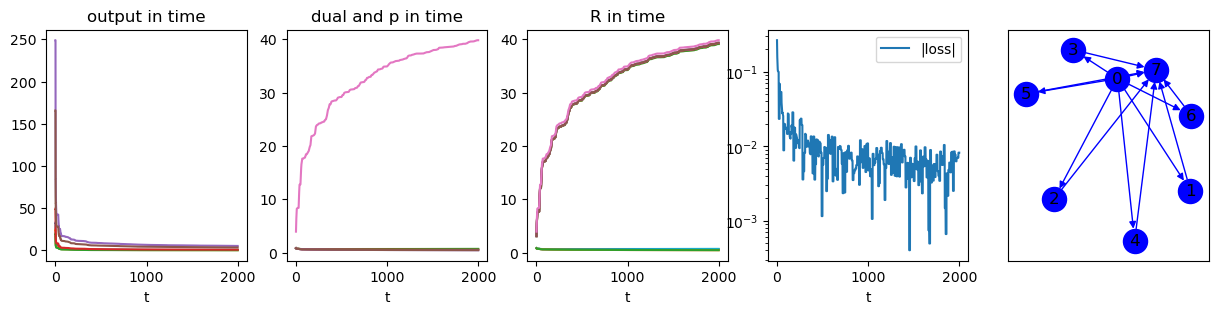

In [17]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

In [49]:
State.output

array([0.01487811, 0.0163508 , 0.01794721, 0.01352219, 0.01157824,
       0.01180682])

In [50]:
State.desired

array([0.02263629, 0.03018171, 0.03772714, 0.01509086, 0.00301817,
       0.00452726])

In [18]:
if np.size(State.Power_norm_in_t)>1:
    plot_functions.plot_Power(State)
else:
    pass

### accuracy

In [19]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [20]:
State.R_in_t[-1]

array([39.22472765, 39.16608968, 39.10252495, 39.27871658, 39.3561193 ,
       39.34701767, 39.81713144,  0.59240379,  0.65104176,  0.71460648,
        0.53841486,  0.46101214,  0.47011377])

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [21]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

u [0.02511482 0.02511482 0.02511482 0.02511482 0.02511482 0.02511482
 0.02511482 0.02511482 0.02511482 0.02511482 0.02511482 0.02511482
 0.02511482]
Rs [39.22472765 39.16608968 39.10252495 39.27871658 39.3561193  39.34701767
 39.81713144  0.59240379  0.65104176  0.71460648  0.53841486  0.46101214
  0.47011377]
Power dissipation 0.17580372435438593


# Save sizes to file

In [22]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

# loss_mat = np.array([[6.00E-05, 1.20E-03, 2.20E-03, 7.20E-03],[5.00E-05, 0.12, 0.16, 0.15], [2.00E-05, 0.18, 0.16, 0.13], [1.10E-03, 0.049, 0.09, 2.6]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

# loss_mat = np.array([[2.8E-13, 9.2E-8, 1.1E-7, 4.3E-5], [7.7E-12, 0.10, 0.18, 0.16], [5.0E-13, 0.15, 0.17, 0.15], [1.2E-7, 0.056, 0.079, 0.068]])
# np.save(save_folder_prelim + 'loss_mat.npy', loss_mat)

# Plots for paper

### Loss afo inputs and outputs

In [23]:
load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/final loss afo Nin Nout normalized loss/7x7/'

loss_mat = np.load(load_folder_prelim + 'loss_mat.npy')

In [24]:
loss_mat

array([[2.76901125e-13, 5.78225659e-09, 1.30236288e-08, 1.31122846e-07,
        2.20861781e-02, 1.52720435e-02, 1.67419616e-02],
       [1.37311149e-11, 2.49818663e-02, 1.34777486e-01, 1.18073233e-01,
        1.09343047e-01, 1.03729116e-01, 1.41493421e-01],
       [7.58072248e-13, 1.66475493e-01, 1.57844903e-01, 1.54713796e-01,
        1.56454700e-01, 1.76364037e-01, 1.75676531e-01],
       [6.61306697e-13, 1.51733152e-01, 1.18293511e-01, 1.84857897e-01,
        2.45669092e-01, 1.35090591e-01, 1.33199179e-01],
       [1.29646192e-02, 1.11692269e-01, 1.64182349e-01, 3.82003445e-01,
        5.51801405e-01, 1.00092081e+00, 4.27882368e-01],
       [1.00520312e+00, 3.52893693e-01, 5.54629095e-01, 6.37823504e-01,
        8.37317480e-01, 6.13267421e-01, 6.23004480e-01],
       [8.76313946e-01, 4.84266882e-01, 3.84852370e-01, 5.20863052e-01,
        5.11482073e-01, 5.82738430e-01, 6.27691132e-01]])

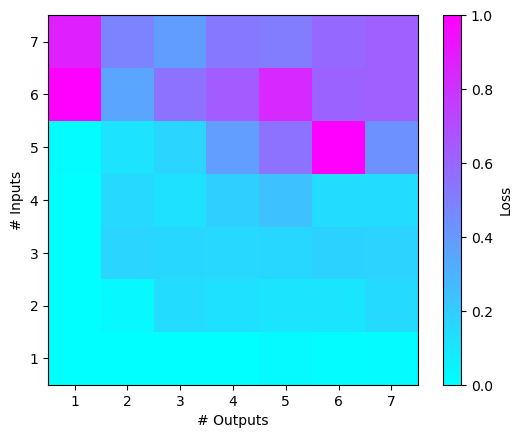

In [25]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(loss_mat)

### R change scheme under 2 tasks

In [26]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

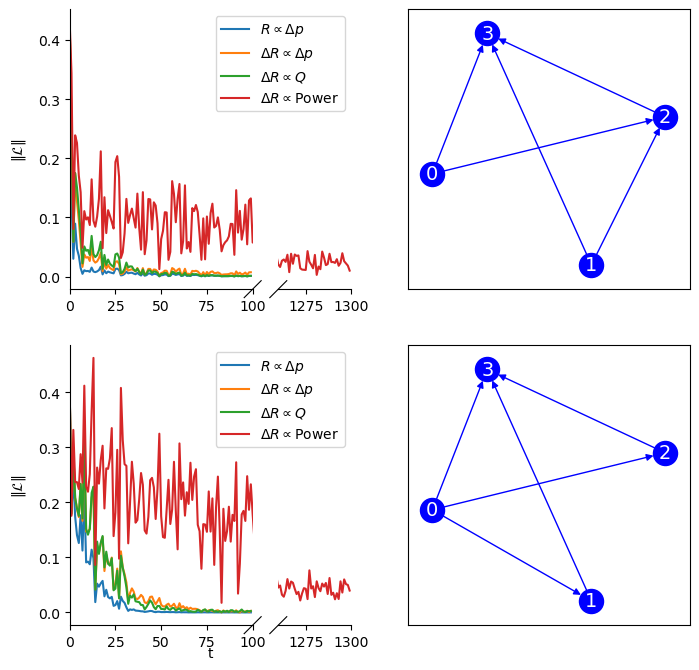

In [27]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [28]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

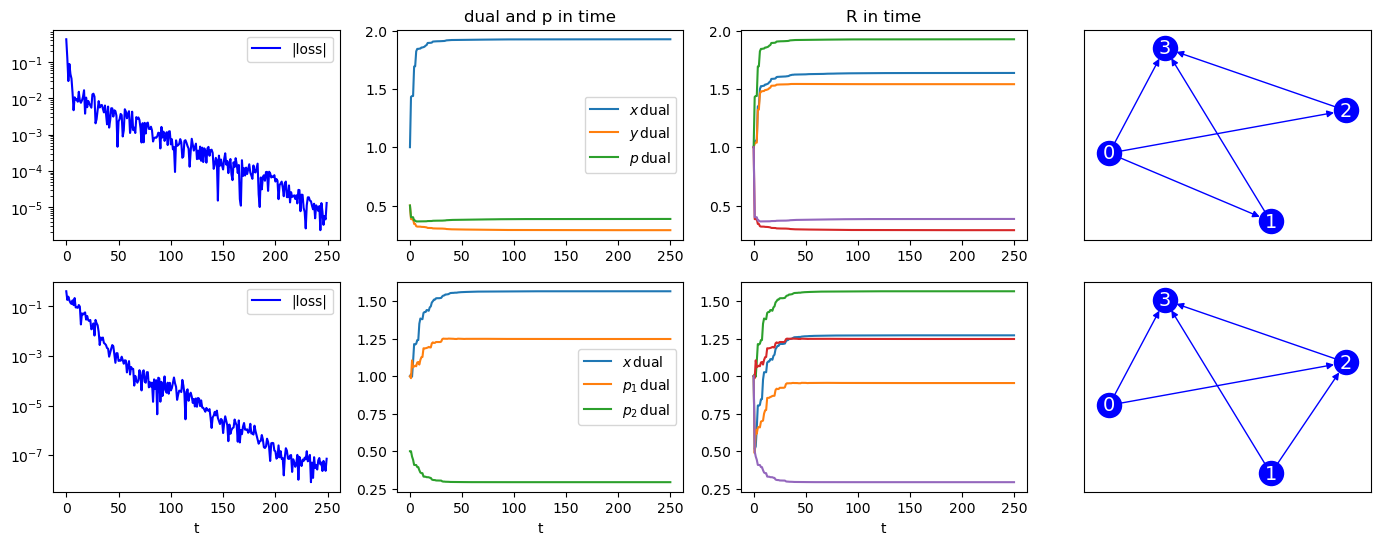

In [29]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

### different R relations

In [30]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [31]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [32]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

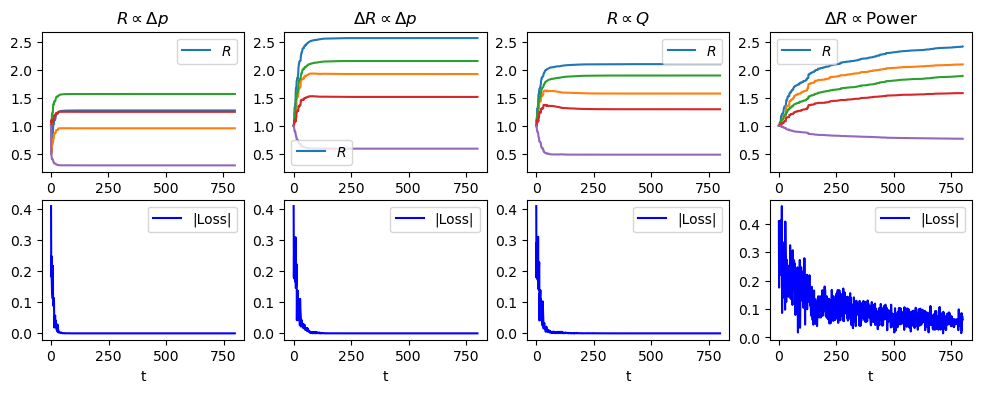

In [33]:
figure_plots.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [34]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [35]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [36]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [37]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

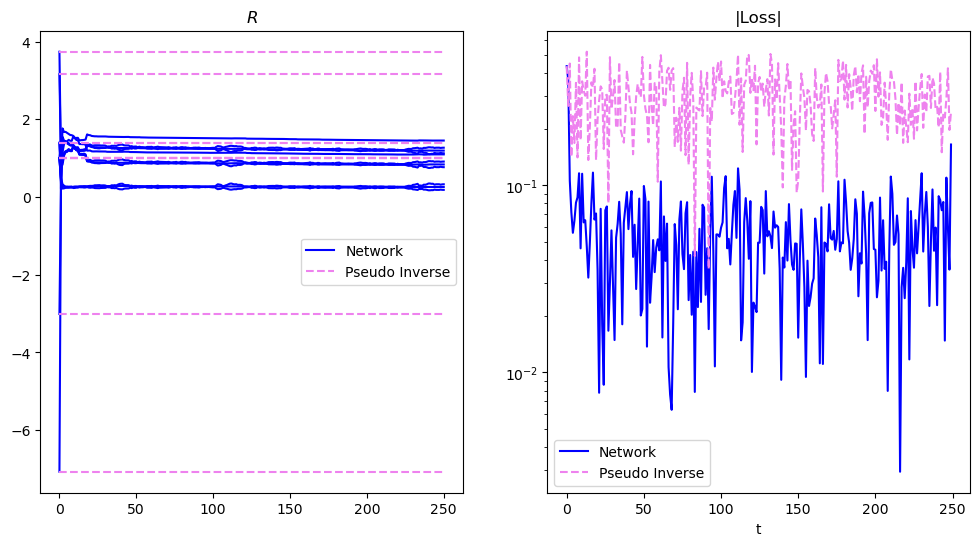

In [38]:
figure_plots.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

## Accuracy classification all materials

In [39]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/R_propto_deltap/t.npy')
dataset_shape = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/R_propto_deltap/dataset_shape.npy')

t_for_accuracy_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/R_propto_deltap/t_for_accuracy.npy')
accuracy_in_t_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/R_propto_deltap/accuracy_in_t.npy')

t_for_accuracy_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_deltap/t_for_accuracy.npy')
accuracy_in_t_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_deltap/accuracy_in_t.npy')

t_for_accuracy_deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_Q/t_for_accuracy.npy')
accuracy_in_t_deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_Q/accuracy_in_t.npy')

t_for_accuracy_deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_Power/t_for_accuracy.npy')
accuracy_in_t_deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/classification different materials/deltaR_propto_Power/accuracy_in_t.npy')

In [40]:
accuracy_in_t_R_propto_deltap

array([0.        , 0.35333333, 0.34666667, 0.34666667, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333,
       0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333

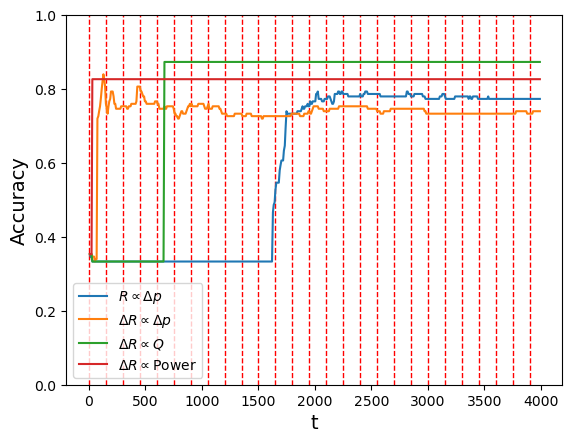

In [41]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_accuracy_4_materials(t_final, dataset_shape,\
                                       t_for_accuracy_R_propto_deltap, accuracy_in_t_R_propto_deltap,\
                                       t_for_accuracy_deltaR_propto_deltap, accuracy_in_t_deltaR_propto_deltap,\
                                       t_for_accuracy_deltaR_propto_Q, accuracy_in_t_deltaR_propto_Q,\
                                       t_for_accuracy_deltaR_propto_Power, accuracy_in_t_deltaR_propto_Power)

## Accuracy classification only R_prop_deltap

In [42]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_final.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/accuracy.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/dataset_len.npy')

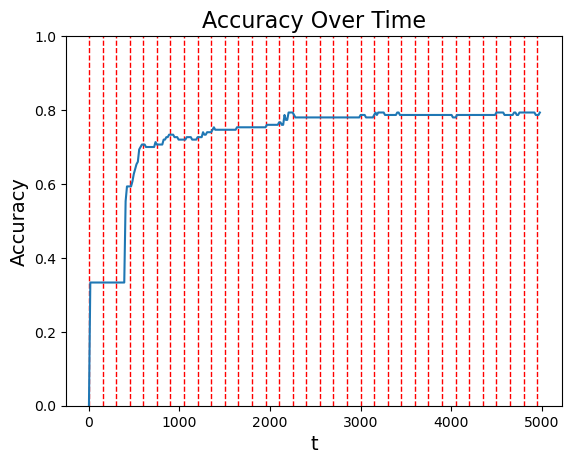

In [43]:
plot_functions.plot_accuracy(t_final, t_for_accuracy, accuracy_in_t, dataset_len)

## Is the network linear?

In [44]:
# # put pressure of 1 through 1st input
# State.input_drawn = np.array([1,0])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 1', State.output)
# out1 = State.output

# # put pressure of 1 through 1st input
# State.input_drawn = np.array([0,1])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 2', State.output)
# out2 = State.output

# print('superpose outputs', out1+out2)

# # put pressure of 1 through inputs
# State.input_drawn = np.ones(Nin)

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output both', State.output)

## Statistics

### Error

In [45]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.6386358031537781


## Checks

In [46]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [47]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)